In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pickle5 as pickle

from sklearn.linear_model import LinearRegression

import analysis_utils as aute

In [2]:
rdm_th = 0
corr_th = 0.85

In [10]:
path_to_conversations = "../Conversations/"

all_df_list, guide_of_times_list = [], []
for subj in os.listdir(path_to_conversations):
    in_folder_subj = os.listdir(path_to_conversations + subj)
    for file in in_folder_subj:
        if ".pkl" not in file:
            path_to_data = path_to_conversations + subj + "/" + file
            pickle_name = [
                conv for conv in os.listdir(path_to_data) if ".pkl" in conv and "Conv" in conv
            ][0]
            try:
                df_x = pd.read_pickle(path_to_data + "/" + pickle_name)
                if df_x.shape[0] > 2:
                    all_df_list.append(df_x)
            except:
                print("Bad file", path_to_data + "/" + pickle_name)
        else:
            try:
                with open(path_to_conversations + subj + "/" + file, 'rb') as f:
                    guide_of_times = pickle.load(f)

                guide_of_times_list.append({
                    subj: guide_of_times
                })
            except:
                print("Not guide in times in subject", subj)
            
print("Number of conversations:", len(all_df_list))

Bad file ../Conversations/Alejandro/Alejandro_20221010_113912/Conv_20221010_113912.pkl
Bad file ../Conversations/Alejandro/Alejandro_20221010_114930/Conv_20221010_114930.pkl
Bad file ../Conversations/Alejandro/Alejandro_20221010_115743/Conv_20221010_115743.pkl
Bad file ../Conversations/Alejandro/Alejandro_20221010_120250/Conv_20221010_120250.pkl
Bad file ../Conversations/Alejandro/Alejandro_20221010_120751/Conv_20221010_120751.pkl
Bad file ../Conversations/Alejandro/Alejandro_20221010_121407/Conv_20221010_121407.pkl
Number of conversations: 6


In [11]:
guide_of_times_list

[{'Jose1': {'Open Eyes GSR': {'InitRealTimeStr': '2022-10-12 12:27:57.455941',
    'InitUnixTime': 1665570477.455941,
    'EndRealTimeStr': '2022-10-12 12:28:07.464050',
    'EndUnixTime': 1665570487.46405},
   'Closed Eyes GSR': {'InitRealTimeStr': '2022-10-12 12:28:09.842492',
    'InitUnixTime': 1665570489.842492,
    'EndRealTimeStr': '2022-10-12 12:28:19.842907',
    'EndUnixTime': 1665570499.842907},
   'Neutral_1': {'InitRealTimeStr': '2022-10-12 12:29:45.767192',
    'InitUnixTime': 1665570585.767192},
   'Happy_Man_1': {'InitRealTimeStr': '2022-10-12 12:33:25.999217',
    'InitUnixTime': 1665570805.999217}}}]

In [12]:
def include_time_columns(data, col_name_init, col_name_end, label):
    
    delta_time = data[col_name_end] - data[col_name_init]

    return {
        "Mean_" + label: np.nanmean(delta_time),
        "Max_" + label: np.nanmax(delta_time),
        "Min_" + label: np.nanmin(delta_time),
        "Diff_" + label: delta_time.dropna().iloc[-1] - delta_time.dropna().iloc[0],
    }

In [17]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["S2TEndUnix"].iloc[-1] - df["UnixTimestampLoopInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="GoogleS2T")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 22.0 +/- 5.831 ; Median = 19.0 ; Min. =  18 ; Max. =  32



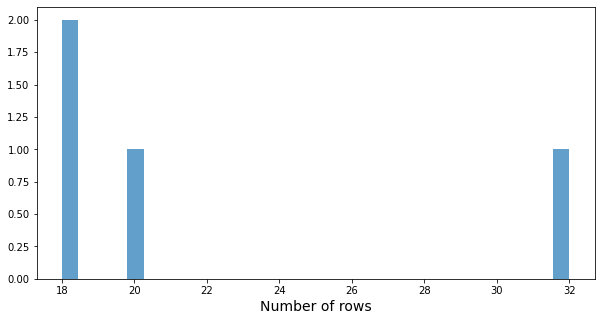

Mean Number of cols = 19.0 +/- 0.0 ; Median = 19.0 ; Min. =  19 ; Max. =  19

Mean Time conversation (min) = 3.5148 +/- 0.9803 ; Median = 3.1644 ; Min. =  2.6436 ; Max. =  5.0869



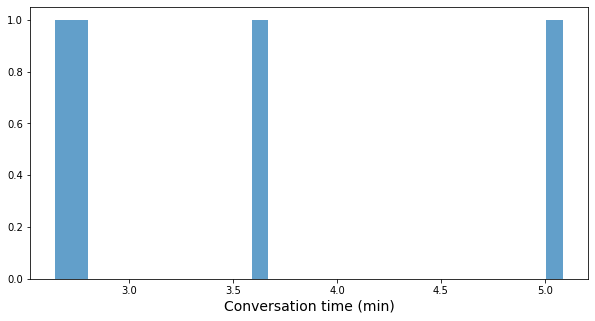

In [18]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.5601 +/- 0.2573 ; Median = 1.5559 ; Min. =  1.2095 ; Max. =  1.9191
Mean Mean_AWStime_s = 0.1691 +/- 0.0404 ; Median = 0.149 ; Min. =  0.1403 ; Max. =  0.2382
Mean Mean_S2Ttime_s = 1.5599 +/- 0.0866 ; Median = 1.5303 ; Min. =  1.4818 ; Max. =  1.6973


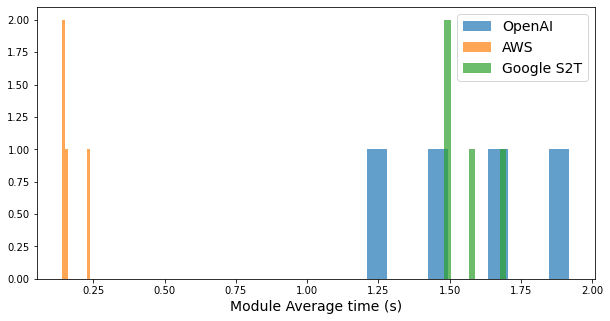

In [22]:
aute.stat_print(df_check["Mean_OpenAI"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWS"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_GoogleS2T"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAI"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWS"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_GoogleS2T"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.0426 +/- 0.2479 ; Median = 1.0172 ; Min. =  0.7498 ; Max. =  1.3863
Mean Mean_AWStime_s = -0.2295 +/- 0.0243 ; Median = -0.2259 ; Min. =  -0.2651 ; Max. =  -0.2012
Mean Mean_S2Ttime_s = -0.1715 +/- 0.0289 ; Median = -0.1725 ; Min. =  -0.2048 ; Max. =  -0.1363


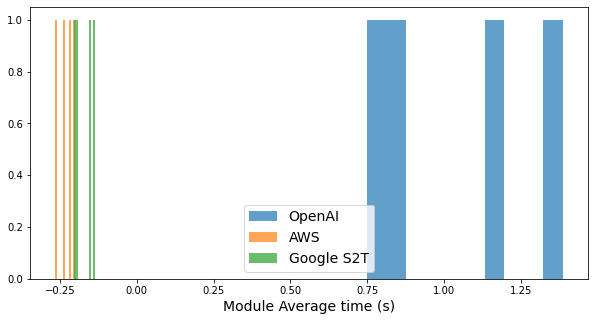

In [23]:
aute.stat_print(df_check["Diff_OpenAI"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Diff_AWS"], "Mean_AWStime_s")
aute.stat_print(df_check["Diff_GoogleS2T"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Diff_OpenAI"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Diff_AWS"], alpha=0.7, label="AWS")
plt.hist(df_check["Diff_GoogleS2T"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [25]:
df.head(5)

,ConversationSentenceId,SubjectId,TimeLoopInitStr,UnixTimestampLoopInit,Source,SpanishMessage,Mode,GlobalMessage,ConfigName,BotStartUnix,BotEndUnix,AWSStartUniX,AWSEndUniX,S2TStartUnix,S2TEndUnix,BotTalkStartUnix,BotTalkEndUnix,PersonTalkStartUnix,PersonTalkEndUnix
0,0,Jose,2022-10-09 14:51:29.8854,1.665320e+09,Bot,"Hola, mi nombre es Alejandra ¿Cómo te llamas tú?",voice,Lo siguiente es una conversación con Alejandra...,Neutral_3,1.665320e+09,1.665320e+09,1.665320e+09,1.665320e+09,NaN,NaN,1.665320e+09,1.665320e+09,NaN,NaN
1,0,Jose,NaN,NaN,Person,Hola Alejandra yo me llamo José qué tal está.,voice,Lo siguiente es una conversación con Alejandra...,Neutral_3,NaN,NaN,NaN,NaN,1.665320e+09,1.665320e+09,NaN,NaN,1.665320e+09,1.665320e+09
2,1,Jose,2022-10-09 14:51:42.950329,1.665320e+09,Bot,"Hola, José. Estoy bien, gracias. ¿Y tú?",voice,Lo siguiente es una conversación con Alejandra...,Neutral_3,1.665320e+09,1.665320e+09,1.665320e+09,1.665320e+09,NaN,NaN,1.665320e+09,1.665320e+09,NaN,NaN
3,1,Jose,NaN,NaN,Person,"Pues yo estoy bien, la verdad llevo todo el dí...",voice,Lo siguiente es una conversación con Alejandra...,Neutral_3,NaN,NaN,NaN,NaN,1.665320e+09,1.665320e+09,NaN,NaN,1.665320e+09,1.665320e+09
4,2,Jose,2022-10-09 14:52:04.849369,1.665320e+09,Bot,¿Y qué es lo que haces?,voice,Lo siguiente es una conversación con Alejandra...,Neutral_3,1.665320e+09,1.665320e+09,1.665320e+09,1.665320e+09,NaN,NaN,1.665320e+09,1.665320e+09,NaN,NaN


In [26]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:

    df_person = df[df["Source"]=="Person"]
    df_bot = df[df["Source"]=="Bot"]

    for i in range(df_bot.shape[0]):
        bot_sentence = df_bot["SpanishMessage"].iloc[i]
        num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
        save_time_dict["AWS_t"]["num_words"].append( num_all_words )
        save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
        save_time_dict["AWS_t"]["time"].append( df_bot["AWSEndUniX"].iloc[i] - df_bot["AWSStartUniX"].iloc[i] )
    
    for i in range(df_person.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
        save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
        save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
        save_time_dict["Google_S2T"]["time"].append( df_person["S2TEndUnix"].iloc[i] - df_person["S2TStartUnix"].iloc[i] )

    for i in range(df_bot.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
        save_time_dict["OpenAI"]["num_words"].append( num_all_words )
        save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
        save_time_dict["OpenAI"]["time"].append( df_bot["BotTalkEndUnix"].iloc[i] - df_bot["BotTalkStartUnix"].iloc[i] )


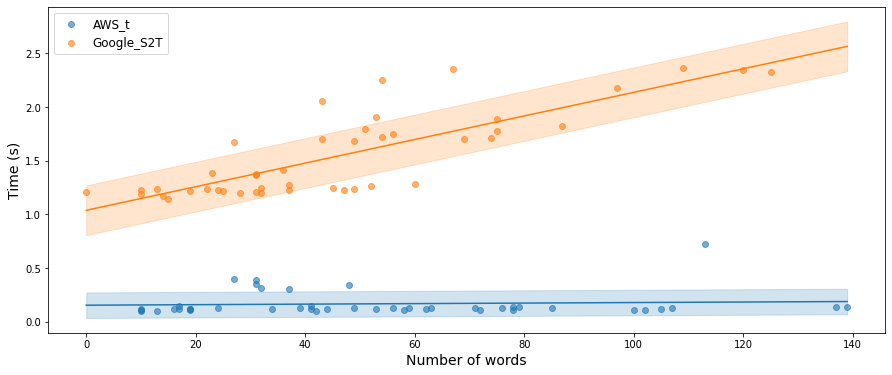

In [34]:
min_num_words = np.min([np.min(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
max_num_words = np.max([np.max(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])

plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":
    
        sort_x_idx = np.argsort(v["num_words"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_words"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred

        x_lim_min_max = np.array([max_num_words, min_num_words])
        y_lim_min_max = lr.predict(x_lim_min_max.reshape(-1, 1))

        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.plot(x_lim_min_max, y_lim_min_max, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_lim_min_max, 
                         y_lim_min_max + err_pred, 
                         y_lim_min_max - err_pred, 
                         alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

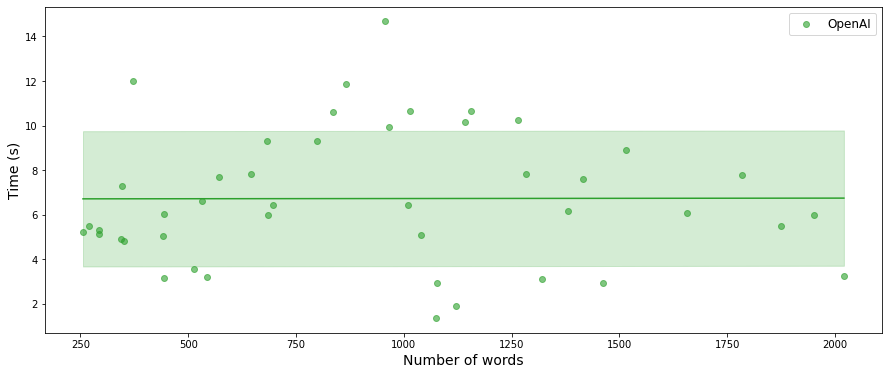

In [35]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_words"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_words"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [65]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
counter = 0
for df in all_df_list:
    
    max_index_take = df[df["Source"] == "Bot"].index[-1]
    df_to_study = df.loc[1:(max_index_take+1)].reset_index(drop=True)

    n_iter = (df_to_study.shape[0] // 2)

    for i in range(n_iter):

        delta_aws_t = (df_to_study["AWSEndUniX"].iloc[2*i+1] - df_to_study["AWSStartUniX"].iloc[2*i+1])
        delta_s2t_t = (df_to_study["S2TEndUnix"].iloc[2*i] - df_to_study["S2TStartUnix"].iloc[2*i])
        delta_bot_t = (df_to_study["BotEndUnix"].iloc[2*i+1] - df_to_study["BotStartUnix"].iloc[2*i+1])

        total_time = df_to_study["BotTalkStartUnix"].iloc[2*i+1] - df_to_study["PersonTalkEndUnix"].iloc[2*i]
        rest_time = total_time - delta_bot_t - delta_s2t_t - delta_aws_t

        save_time_list += [
            {
                "Iteration": counter,
                "Source": "AWS",
                "Time": delta_aws_t
            }, 
            {
                "Iteration": counter,
                "Source": "S2T",
                "Time": delta_s2t_t
            }, 
            {
                "Iteration": counter,
                "Source": "OpenAI",
                "Time": delta_bot_t
            }, 
            {
                "Iteration": counter,
                "Source": "Total",
                "Time": total_time
            }, 
            {
                "Iteration": counter,
                "Source": "Rest",
                "Time": rest_time
            }
        ]

        counter += 1
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (200, 3)


In [66]:
df_times

,Iteration,Source,Time
0,0,AWS,0.134722
1,0,S2T,1.362967
2,0,OpenAI,2.632019
3,0,Total,5.527828
4,0,Rest,1.398120
...,...,...,...
195,39,AWS,0.103124
196,39,S2T,1.232175
197,39,OpenAI,0.749828
198,39,Total,2.353575


In [67]:
all_times_list = []
for g, df_g in df_times.groupby("Iteration"):
    dict_times = dict(zip(df_g["Source"].values.tolist(), df_g["Time"].values.tolist()))
    all_times_list.append(dict_times)
df_all_t_sources = pd.DataFrame(all_times_list)

df_all_t_sources.to_csv("SaveToBoxplot.csv", index=False)

23.4517

In [79]:
for col in df_all_t_sources.columns:
    print("Source", col, "takes:")
    aute.stat_print(df_all_t_sources[col], col)
    print("In percentage", np.round(100 * np.sum(df_all_t_sources[col])/np.sum(df_all_t_sources["Total"]), 4), "%")
    print()

Source AWS takes:
Mean AWS = 0.1493 +/- 0.1078 ; Median = 0.1223 ; Min. =  0.1008 ; Max. =  0.727
In percentage 3.2908 %

Source S2T takes:
Mean S2T = 1.5846 +/- 0.3927 ; Median = 1.3968 ; Min. =  1.1473 ; Max. =  2.3612
In percentage 34.9323 %

Source OpenAI takes:
Mean OpenAI = 1.7385 +/- 0.5896 ; Median = 1.742 ; Min. =  0.6299 ; Max. =  3.4113
In percentage 38.3252 %

Source Total takes:
Mean Total = 4.5361 +/- 0.9371 ; Median = 4.4584 ; Min. =  2.3536 ; Max. =  6.4646
In percentage 100.0 %

Source Rest takes:
Mean Rest = 1.0638 +/- 0.3716 ; Median = 1.0398 ; Min. =  0.2684 ; Max. =  1.7251
In percentage 23.4517 %



In [80]:
all_diff = df_all_t_sources["Total"] - np.sum(df_all_t_sources[["Rest", "OpenAI", "S2T", "AWS"]], axis=1)
np.max(all_diff)

0.0

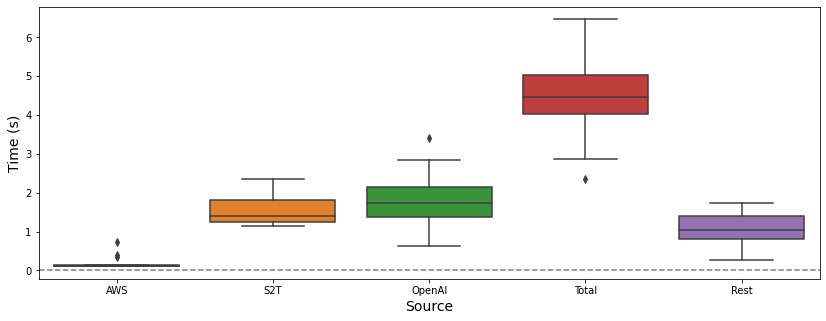

In [81]:
plt.figure(figsize=(14, 5))
sns.boxplot(x="Source", y="Time", data=df_times)

plt.axhline(0, c="black", linestyle="--", alpha=0.5)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.savefig('../Documents/Images/save_boxplot.pdf', format='pdf')

plt.show()